In [133]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt


# Hi from Andrew
# Just click "Run All" and our main figure will me in main_figures.png
# The z-normalized dataset will be in mfd2_annotated_z.csv
# If you don't want to run the code everything is in generated_files


In [134]:
# luh bit of preprocessing

df = pd.read_csv('raw_study_2.csv')

df = df[df['Pref. (White asc.)'].isnull() & df['Pref. (White desc.)'].isnull()]

columns_to_remove = [
    "StartDate", "EndDate", "Status", "IPAddress", "Progress", "Duration (in seconds)",
    "Finished", "RecordedDate", "ResponseId", "RecipientLastName", "RecipientFirstName",
    "RecipientEmail", "ExternalReference", "LocationLatitude", "LocationLongitude",
    "DistributionChannel", "UserLanguage", "comprehension_1", "comprehension_2",
    "Gender_5_TEXT", "Hispanic", "Political aff._4_TEXT", "Independent Q"
]

df = df.drop(columns=columns_to_remove, axis=1)

df.to_csv('black_survey_responses.csv', index=False)


In [135]:
# Create a mapping dictionary for the replacements
replace_dict = {'Option A': 'Option E', 'Option B': 'Option D', 'Option D': 'Option B', 'Option E': 'Option A'}

# Modify the values in the "Pref. (Black desc.)" column
df['Pref. (Black desc.)'] = df['Pref. (Black desc.)'].replace(replace_dict)

# Print the updated DataFrame
df.to_csv('black_survey_responses_flipped.csv', index=False)


In [136]:
df = pd.read_csv('black_survey_responses_flipped.csv')

columns_to_remove = ["Pref. (White asc.)", "Pref. (White desc.)"]
df = df.drop(columns=columns_to_remove)

df['choice'] = df['Pref. (Black asc.)'].combine_first(df['Pref. (Black desc.)'])
columns_to_remove = ["Pref. (Black asc.)", "Pref. (Black desc.)"]
df = df.drop(columns=columns_to_remove)
df.to_csv('black_survey_responses_flipped_comb.csv')


In [137]:
# cell to add the columns we will use for the bag of words process
# I don't know whether I need to do this explicitly but I will anyway

df = pd.read_csv('black_survey_responses_flipped_comb.csv')

new_columns = ['efficiency.virtue', 'efficiency.vice', 'fairness.virtue', 'loyalty.virtue', 'authority.virtue',
               'sanctity.virtue', 'care.virtue', 'fairness.vice', 'loyalty.vice', 'authority.vice',
               'sanctity.vice', 'care.vice', 'fairness.comb', 'loyalty.comb', 'authority.comb',
               'sanctity.comb', 'care.comb', 'efficiency.comb']

for column in new_columns:
    df[column] = 0

df.to_csv('black_survey_responses_flipped_comb.csv', index=False)


In [138]:
# this is the main bag of words implementation

file_path = "efficiency_mfd2.dic"
hashmap = {}

with open(file_path, "r") as file:
    for line in file:
        line = line.strip()
        
        if not line or line.startswith("%"):
            continue
        
        phrase, header = line.split("\t")
        hashmap[phrase] = header

words = []

with open(file_path, "r") as file:
    for line in file:
        line = line.strip()
        
        if not line or line.startswith("%"):
            continue
        
        phrase, header = line.split("\t")
        words.append(phrase)

df = pd.read_csv("black_survey_responses_flipped_comb.csv")
k = 0
for title in df["Pref. explanation"]:
    k = k+1
    for word in words:
        
        if word in title and not word.isdigit():
            print(k)
            word_key = hashmap[word]
            final_key = hashmap[word_key]
            
            df.loc[df['Pref. explanation'] == title, final_key] = df.loc[df['Pref. explanation'] == title, final_key] + 1


            print(word + " was registered as " + final_key)


df.to_csv("mfd2_annotated.csv")

1
fair was registered as fairness.virtue
1
proportional was registered as fairness.virtue
1
group was registered as loyalty.virtue
2
more was registered as efficiency.virtue
4
help was registered as care.virtue
4
most was registered as efficiency.virtue
5
more was registered as efficiency.virtue
6
number was registered as efficiency.virtue
7
equal was registered as fairness.virtue
7
ally was registered as loyalty.virtue
7
group was registered as loyalty.virtue
7
groups was registered as loyalty.virtue
8
fair was registered as fairness.virtue
9
help was registered as care.virtue
9
fair was registered as fairness.virtue
9
unfair was registered as fairness.vice
9
most was registered as efficiency.virtue
10
justice was registered as fairness.virtue
10
fair was registered as fairness.virtue
10
level the playing field was registered as fairness.virtue
10
unfair was registered as fairness.vice
10
ally was registered as loyalty.virtue
10
systematic was registered as efficiency.virtue
10
system

In [139]:
# We do not care about virtue or vice, just treat it as invoking a moral

df = pd.read_csv('mfd2_annotated.csv')

df['fairness.comb'] = df['fairness.virtue'] + df['fairness.vice']
df['loyalty.comb'] = df['loyalty.virtue'] + df['loyalty.vice']
df['authority.comb'] = df['authority.virtue'] + df['authority.vice']
df['sanctity.comb'] = df['sanctity.virtue'] + df['sanctity.vice']
df['care.comb'] = df['care.virtue'] + df['care.vice']
df['efficiency.comb'] = df['efficiency.virtue'] + df['efficiency.vice']

df.to_csv('mfd2_annotated.csv', index=False)

In [140]:
# word count cell

df = pd.read_csv('mfd2_annotated.csv')

df['word_count'] = df['Pref. explanation'].apply(lambda x: len(str(x).split()))


column_mapping = {
    'fairness.comb': 'Fairness',
    'efficiency.comb': 'Efficiency',
    'authority.comb': 'Authority',
    'sanctity.comb': 'Sanctity',
    'loyalty.comb': 'Loyalty',
    'care.comb': 'Care'
}

df.rename(columns=column_mapping, inplace=True)

df.to_csv('mfd2_annotated_z.csv', index=False)
columns_to_divide = list(column_mapping.values())
df[columns_to_divide] = df[columns_to_divide].div(df['word_count'], axis=0)

df.to_csv('mfd2_annotated.csv', index=False)


In [141]:
df = pd.read_csv('mfd2_annotated.csv')

columns_to_transform = ['Fairness', 'Loyalty', 'Authority', 'Sanctity', 'Care','Efficiency'] 
data = df[columns_to_transform].values

means = np.mean(data, axis=0)
stds = np.std(data, axis=0)

print(means) 

print(stds) 


z_transformed_data = (data - means) / stds

df_transformed = pd.DataFrame(z_transformed_data, columns=columns_to_transform)

df_transformed.to_csv('mfd2_annotated_z.csv', index=False)


[0.04312673 0.01435715 0.00216473 0.00321039 0.01388878 0.06878205]
[0.07550953 0.03424375 0.02102992 0.0133143  0.04163703 0.06950765]


In [142]:
surv = pd.read_csv('black_survey_responses_flipped_comb.csv')

flonk = pd.read_csv('mfd2_annotated_z.csv')

columns_to_add = ['Birth year', 'Gender', 'Race', 'Political aff.', 'Education', 'Income', 'choice']
flonk[columns_to_add] = surv[columns_to_add]
df = pd.read_csv('mfd2_annotated.csv')

flonk['word_count'] = df[['word_count']]

flonk.to_csv('mfd2_annotated_z.csv', index=False)


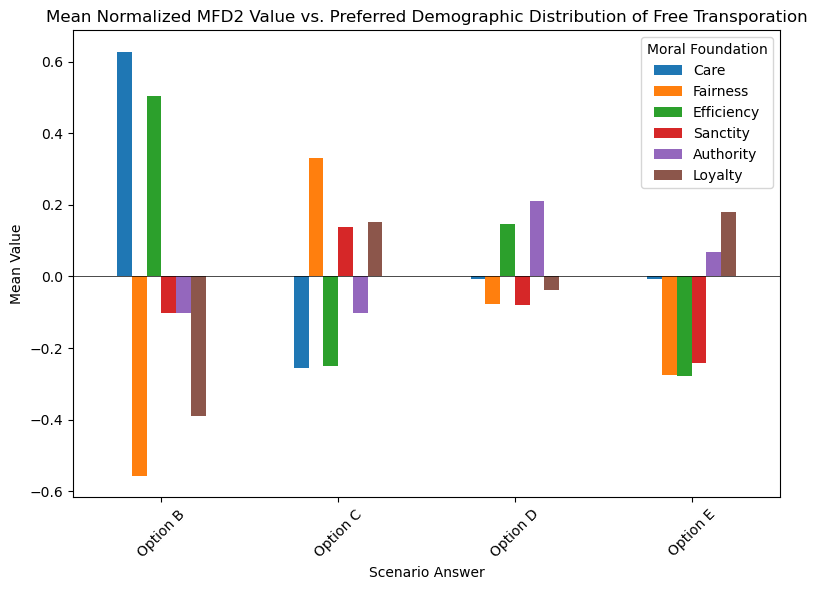

In [144]:
df = pd.read_csv('mfd2_annotated_z.csv')

foundations = ['Care', 'Fairness', 'Efficiency', 'Sanctity', 'Authority', 'Loyalty']

fig, ax = plt.subplots(figsize=(8, 6))

scenario = 'choice'
scenario_answers = df[scenario].unique()
data = pd.DataFrame(index=scenario_answers, columns=foundations)

for answer in scenario_answers:
    filtered_data = df[df[scenario] == answer][foundations]
    data.loc[answer] = filtered_data.mean()

data['sort_value'] = data.index.str.extract(r'Option ([B-E])', expand=False)
data = data.sort_values('sort_value')
data.drop('sort_value', axis=1, inplace=True)


ax = data.plot(kind='bar', ax=ax)

ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

ax.set_xlabel('Scenario Answer')
ax.set_ylabel('Mean Value')
ax.set_title(f'Mean Normalized MFD2 Value vs. Preferred Demographic Distribution of Free Transporation')
ax.legend(title='Moral Foundation')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
fig.savefig('main_figures.png', dpi=300)
